In [1]:
from Bio import SeqIO
from collections import Counter
import pandas as pd 
import re
import requests
import json
import time
import glob
import pprint
import seaborn as sns
import pylab as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
import pycountry 
import pycountry_convert as pc
pp = pprint.PrettyPrinter()
import numpy as np
from tabulate import tabulate
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import regex as re
import plotly.graph_objects as go
import os

from string import punctuation
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
import nltk
from bs4 import BeautifulSoup


 

stemmer=SnowballStemmer("english")
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import networkx as nx
from collections import defaultdict
from itertools import combinations
#from fa2 import ForceAtlas2

import textmining
  

%env folder = X:\5_Research\Paul\dsi_origins\

env: folder=X:\5_Research\Paul\dsi_origins\


In [2]:
path = %env folder

### 1. Data pre-processing

In [4]:
df_scholarly = pd.read_csv(path+R'processed_data/scholarly_aff_group.csv', index_col = 0)

In [8]:
len(set(df_scholarly['id_select']))

94772

In [10]:
#explore how many publication have titles, keywords, abstracts, fulltext
len(set(df_scholarly['id_select'][df_scholarly['title'].notna()]))

94772

In [12]:
#explore how many publication have titles, keywords, abstracts, fulltext
len(set(df_scholarly['id_select'][df_scholarly['abstract'].notna()]))

75733

In [14]:
#difference between titles and abstract coverage
len(set(df_scholarly['id_select'][df_scholarly['title'].notna()])) -len(set(df_scholarly['id_select'][df_scholarly['abstract'].notna()]))

19039

In [10]:
titles = list(set(df_scholarly['title']))

In [11]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(nltk_pos_tag):
    if nltk_pos_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_pos_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_pos_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

# Function to lemmatize a title with POS tagging
def lemmatize_title(title):
    words = word_tokenize(title.lower())
    pos_tagged_words = nltk.pos_tag(words)
    
    lemmatized_words = [
        lemmatizer.lemmatize(word, get_wordnet_pos(pos_tag)) 
        for word, pos_tag in pos_tagged_words
    ]
    
    return ' '.join(lemmatized_words)

lemmatized_titles = []


for title in titles: 
    lemmatized_title = lemmatize_title(title)
    lemmatized_titles.append(lemmatized_title)

In [12]:
# Define the set of spelled-out numbers to remove
spelled_out_numbers = {'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten',
                       'eleven', 'twelve', 'thirteen', 'fourteen', 'fifteen', 'sixteen', 'seventeen', 'eighteen',
                       'nineteen', 'twenty', 'thirty', 'forty', 'fifty', 'sixty', 'seventy', 'eighty', 'ninety', 
                       'hundred', 'thousand', 'million', 'billion','first', 'firstly', 'second', 'secondly', 'third', 'thirdly'}

# Define the set of countries, geographic regions, and their adjectives (demonyms) to remove
countries_and_regions = {'afghanistan', 'albania', 'algeria', 'andorra', 'angola', 'argentina', 'armenia', 'australia', 
                         'austria', 'azerbaijan', 'bahamas', 'bahrain', 'bangladesh', 'barbados', 'belarus', 'belgium', 
                         'belize', 'benin', 'bhutan', 'bolivia', 'bosnia', 'botswana', 'brazil', 'bulgaria', 'burkina', 
                         'burundi', 'cambodia', 'cameroon', 'canada', 'chad', 'chile', 'china', 'colombia', 'comoros', 
                         'congo', 'costa rica', 'croatia', 'cuba', 'cyprus', 'czech', 'denmark', 'djibouti', 'dominica', 'ecuador', 
                         'egypt', 'eritrea', 'estonia', 'eswatini', 'ethiopia', 'fiji', 'finland', 'france', 'gabon', 
                         'gambia', 'georgia', 'germany', 'ghana', 'greece', 'grenada', 'guatemala', 'guinea', 'guyana', 
                         'haiti', 'honduras', 'hungary', 'iceland', 'india', 'indonesia', 'iran', 'iraq', 'ireland', 
                         'israel', 'italy', 'jamaica', 'japan', 'jordan', 'kazakhstan', 'kenya', 'kiribati', 'kuwait', 
                         'kyrgyzstan', 'laos', 'latvia', 'lebanon', 'lesotho', 'liberia', 'libya', 'liechtenstein', 
                         'lithuania', 'luxembourg', 'madagascar', 'malawi', 'malaysia', 'maldives', 'mali', 'malta', 
                         'mauritania', 'mauritius', 'mexico', 'moldova', 'monaco', 'mongolia', 'montenegro', 'morocco', 
                         'mozambique', 'myanmar', 'namibia', 'nepal', 'netherlands', 'new zealand', 'nicaragua', 'niger', 
                         'nigeria', 'north korea', 'north macedonia', 'norway', 'oman', 'pakistan', 'palau', 'panama', 
                         'papua new guinea', 'paraguay', 'peru', 'philippines', 'poland', 'portugal', 'qatar', 'romania', 
                         'russia', 'rwanda', 'samoa', 'san marino', 'saudi arabia', 'senegal', 'serbia', 'seychelles', 
                         'sierra leone', 'singapore', 'slovakia', 'slovenia', 'somalia', 'south africa', 'south korea', 
                         'spain', 'sri lanka', 'sudan', 'suriname', 'sweden', 'switzerland', 'syria', 'tajikistan', 
                         'tanzania', 'thailand', 'togo', 'tonga', 'tunisia', 'turkey', 'turkmenistan', 'uganda', 'ukraine', 
                         'united arab emirates', 'united kingdom', 'united states', 'uruguay', 'uzbekistan', 'vanuatu', 
                         'venezuela', 'vietnam', 'yemen', 'zambia', 'zimbabwe',
                         # Geographic regions
                         'africa', 'asia', 'europe', 'america', 'north america', 'south america', 'oceania', 'antarctica', 
                         'middle east', 'eastern europe', 'western europe', 'northern europe', 'southern europe', 'latin america'}

# Add country-based adjectives (demonyms) to the list
demonyms = {'afghan', 'albanian', 'algerian', 'andorran', 'angolan', 'argentine', 'armenian', 'australian', 'austrian',
            'azerbaijani', 'bahamian', 'bahraini', 'bangladeshi', 'barbadian', 'belarusian', 'belgian', 'belizean', 
            'beninese', 'bhutanese', 'bolivian', 'bosnian', 'botswanan', 'brazilian', 'bulgarian', 'burkinabe', 
            'burundian', 'cambodian', 'cameroonian', 'canadian', 'chadian', 'chilean', 'chinese', 'colombian', 'comorian', 
            'congolese', 'costa rican','croatian', 'cuban', 'cypriot', 'czech', 'danish', 'djiboutian', 'dominican', 'ecuadorian', 
            'egyptian', 'eritrean', 'estonian', 'eswatini', 'ethiopian', 'fijian', 'finnish', 'french', 'gabonese', 
            'gambian', 'georgian', 'german', 'ghanaian', 'greek', 'grenadian', 'guatemalan', 'guinean', 'guyanese', 
            'haitian', 'honduran', 'hungarian', 'icelandic', 'indian', 'indonesian', 'iranian', 'iraqi', 'irish', 
            'israeli', 'italian', 'jamaican', 'japanese', 'jordanian', 'kazakh', 'kenyan', 'kiribati', 'kuwaiti', 
            'kyrgyz', 'laotian', 'latvian', 'lebanese', 'lesothan', 'liberian', 'libyan', 'liechtensteiner', 'lithuanian', 
            'luxembourger', 'malagasy', 'malawian', 'malaysian', 'maldivian', 'malian', 'maltese', 'mauritanian', 
            'mauritian', 'mexican', 'moldovan', 'monacan', 'mongolian', 'montenegrin', 'moroccan', 'mozambican', 'myanmarese', 
            'namibian', 'nepalese', 'dutch', 'new zealander', 'nicaraguan', 'nigerien', 'nigerian', 'north korean', 
            'macedonian', 'norwegian', 'omani', 'pakistani', 'palauan', 'panamanian', 'papua new guinean', 'paraguayan', 
            'peruvian', 'philippine', 'polish', 'portuguese', 'qatari', 'romanian', 'russian', 'rwandan', 'samoan', 
            'san marinese', 'saudi', 'senegalese', 'serbian', 'seychellois', 'sierra leonean', 'singaporean', 'slovak', 
            'slovenian', 'somali', 'south african', 'south korean', 'spanish', 'sri lankan', 'sudanese', 'surinamese', 
            'swazi', 'swedish', 'swiss', 'syrian', 'tajik', 'tanzanian', 'thai', 'togolese', 'tongan', 'tunisian', 
            'turkish', 'turkmen', 'ugandan', 'ukrainian', 'emirati', 'british', 'american', 'uruguayan', 'uzbek', 
            'vanuatuan', 'venezuelan', 'vietnamese', 'yemeni', 'zambian', 'zimbabwean', 'african', 'asian', 'european',  'mediterrenean', 'pacific', 'atlantic', 'usa', 'korea', 'republic', 'taiwan'}

# Merge countries, regions, and demonyms into a single set for filtering
countries_regions_demonyms = countries_and_regions.union(demonyms)

# Define additional stopwords if needed
own_stopwords = ['ci', 'sp', 'spp', 'title', 'summary', 'background','north', 'northern', 'south','southern','east','eastern','west','western', 'southwest', 'southeastern','southwest','southwestern', 'northeast','northeastern', 'northwest','northwestern',  'et', 'al', 'de', 'ii']
mystopwords = stopwords.words("english") + own_stopwords


titles_cleaned_stopwords = []


# Remove countries, regions, adjectives, numbers (written and actual), and other unwanted words
words_counter = Counter()
for title in lemmatized_titles:
    title_clean = ''
    for word in title.split():
        word_cleaned = "".join([l for l in word if l not in punctuation]).lower()
        
        # Remove stopwords, digits, spelled-out numbers, country names, regions, and adjectives (demonyms)
        if (word_cleaned not in mystopwords and 
            not word_cleaned.isdigit() and 
            word_cleaned not in spelled_out_numbers and 
            word_cleaned not in countries_regions_demonyms and 
            len(word_cleaned) > 1):
            #if word_cleaned in replace_dict.keys(): 
            #    word_cleaned = replace_dict[word_cleaned]
            
            if title_clean == '':
                title_clean = word_cleaned
            else:
                title_clean = title_clean + ' ' + word_cleaned
                
    titles_cleaned_stopwords.append(title_clean)
    words_counter.update(list(set(title_clean.split())))
titles_cleaned_stopwords[:10]


['environmental surveillance molecular characterization human enteric virus tropical urban wastewater',
 'detection dengue virus central',
 'nonmonophyly intricate morphological evolution within avian family cettiidae reveal multilocus analysis taxonomically densely sample dataset',
 'amie novel nacylhomoserine lactone acylase belong amidase family activatedsludge isolate acinetobacter strain ooi24',
 'characterization novel allelic variant hlab lineage hlab clone sequence',
 'transcriptome analysis detoxificationrelated gene spodoptera frugiperda lepidoptera noctuidae',
 'viral discovery invasive cane toad rhinella marina use metatranscriptomic genomic approach',
 'integrative insight diversity distribution biogeography freshwater endemic clade ponticola syrman group teleostei gobiidae caucasus biodiversity hotspot',
 'zebrafish sox9 gene require cartilage morphogenesis',
 'outbreak hepatitis virus infection high casefatality rate among inject drug user']

In [13]:
words_counter.most_common()

[('virus', 14161),
 ('isolate', 9616),
 ('molecular', 9351),
 ('characterization', 8934),
 ('specie', 8244),
 ('sequence', 8187),
 ('gene', 8066),
 ('analysis', 7399),
 ('new', 6920),
 ('genome', 6670),
 ('novel', 6264),
 ('genetic', 5979),
 ('strain', 5937),
 ('nov', 5875),
 ('diversity', 5656),
 ('human', 4434),
 ('identification', 4357),
 ('infection', 3965),
 ('complete', 3807),
 ('phylogenetic', 3750),
 ('detection', 3601),
 ('dna', 3236),
 ('type', 3203),
 ('genus', 3162),
 ('associate', 2922),
 ('population', 2732),
 ('use', 2702),
 ('disease', 2655),
 ('isolates', 2582),
 ('mitochondrial', 2534),
 ('evolution', 2464),
 ('soil', 2433),
 ('resistance', 2407),
 ('protein', 2275),
 ('community', 2260),
 ('phylogeny', 2215),
 ('among', 2144),
 ('evidence', 2126),
 ('genotype', 2094),
 ('isolation', 2027),
 ('hepatitis', 2019),
 ('bacteria', 2019),
 ('patient', 1999),
 ('report', 1981),
 ('region', 1944),
 ('expression', 1923),
 ('cause', 1909),
 ('reveal', 1889),
 ('influenza', 1856

In [14]:
len(list(words_counter.keys()))

92319

In [15]:
bottomfiltered_words_counter = Counter({key: value for key, value in words_counter.items() if value > 2})


In [16]:
len(list(bottomfiltered_words_counter.keys()))

24229

In [17]:
words_to_keep = list(bottomfiltered_words_counter.keys())

In [18]:
titles_cleaned = []
titles_cleaned_stopwords_cut = []
#nr = 1
for title in titles_cleaned_stopwords:
    cleaned_title = ''
    for word in title.split(): 
        if word in words_to_keep:
            if cleaned_title == '': 
                cleaned_title = word
            else: 
                cleaned_title = cleaned_title + ' ' + word
    title_length = len(cleaned_title.split())

    titles_cleaned.append(cleaned_title)
    titles_cleaned_stopwords_cut.append(title)
    
    #if title_length <= 2: 
    #    print('smallllll')
    #    print(title)
    #    print(cleaned_title)
    #elif title_length >= 26: 
    #    print('largeee')
    #    print(title)
    #    print(cleaned_title)
    #nr = nr +1
    #print(nr)
    #if nr == 4: 
    #    break
    #if til

In [19]:
ori_cle_title_dict = dict(zip(titles, titles_cleaned))

In [20]:
df_scholarly['title_clean'] = df_scholarly['title'].map(ori_cle_title_dict)

In [21]:
df_scholarly_clean = df_scholarly[df_scholarly['title_clean']!= '']

In [23]:
df_scholarly_clean.to_csv(path+R'processed_data\scholarly_title_cleaned.csv')

### 3. Create TF-IDF weights for filtering out words that occur similary often/little across all documents 

In [ ]:
#df_scholarly_clean = pd.read_csv(path+R'processed_data\scholarly_title_cleaned.csv', index_col = 0)

In [24]:
df_scholarly_clean_nd = df_scholarly_clean[['id_select','title_clean']].drop_duplicates() #cannot just drop duplicate titles (in combination with ids as done here is better) because some of the duplicats are a result of the cleaning rather than actual duplicates

In [25]:
titles_cleaned_nodup = df_scholarly_clean_nd['title_clean'].tolist()

In [26]:
len(titles_cleaned_nodup)

94761

C:\Users\a494-nipw010\AppData\Local\Temp\ipykernel_9304\1132822237.py:46: RuntimeWarning: invalid value encountered in divide
  average_log_tfidf = log_tfidf_sums / rank_counts


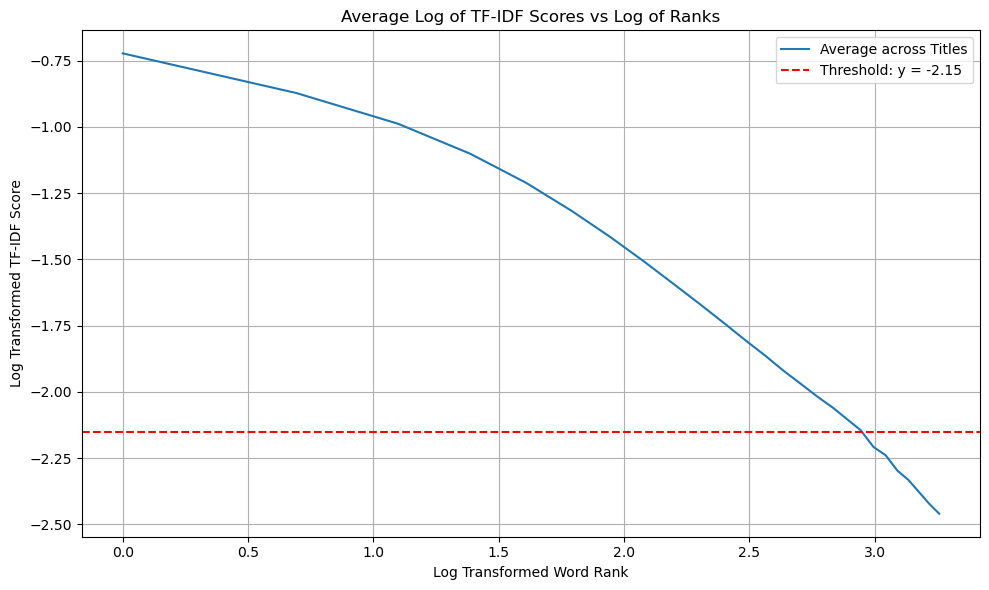

In [27]:
# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer() #max_df=0.95, min_df=4

# Fit the TF-IDF model and transform the titles into a sparse TF-IDF matrix
tfidf_matrix = vectorizer.fit_transform(titles_cleaned_nodup)

# Get the feature names (words) and their corresponding indices in the TF-IDF matrix
feature_names = vectorizer.get_feature_names_out()

# Step 2: Prepare lists to store log TF-IDF and log rank for averaging
max_rank = 1000  # Set a max rank cutoff to avoid extreme outliers; can be adjusted
log_tfidf_sums = np.zeros(max_rank)
rank_counts = np.zeros(max_rank)

# For each title (row in the tfidf_matrix), compute log TF-IDF vs log rank
for i in range(tfidf_matrix.shape[0]):
    # Get the non-zero indices and corresponding TF-IDF scores for the current title
    row = tfidf_matrix.getrow(i)
    non_zero_indices = row.indices
    non_zero_scores = row.data
    
    title_word_scores = pd.DataFrame({
        'word': feature_names[non_zero_indices],
        'tfidf_score': non_zero_scores
    })
    
    # Sort the words by TF-IDF score in descending order
    title_word_scores_sorted = title_word_scores.sort_values(by='tfidf_score', ascending=False)
    
    # Assign ranks
    title_word_scores_sorted['rank'] = np.arange(1, len(title_word_scores_sorted) + 1)
    
    # Remove any zero TF-IDF scores
    title_word_scores_sorted = title_word_scores_sorted[title_word_scores_sorted['tfidf_score'] > 0]
    
    # Compute the logarithms of TF-IDF scores and ranks
    log_tfidf = np.log(title_word_scores_sorted['tfidf_score'])
    log_rank = np.log(title_word_scores_sorted['rank'])
    
    # Limit to max_rank to avoid very high ranks (optional)
    for j in range(min(len(log_tfidf), max_rank)):
        log_tfidf_sums[j] += log_tfidf.iloc[j]
        rank_counts[j] += 1

# Step 3: Calculate the average log TF-IDF scores for each rank
average_log_tfidf = log_tfidf_sums / rank_counts

# Generate a log rank axis for plotting (from 1 to max_rank)
log_rank_axis = np.log(np.arange(1, max_rank + 1))

# Step 4: Plot the average log TF-IDF scores vs log rank
plt.figure(figsize=(10, 6))
plt.plot(log_rank_axis, average_log_tfidf, label='Average across Titles')

# Add a threshold line (at y = -2.15 in this case)
plt.axhline(y=-2.15, color='red', linestyle='--', label='Threshold: y = -2.15')

plt.title('Average Log of TF-IDF Scores vs Log of Ranks')
plt.xlabel('Log Transformed Word Rank')
plt.ylabel('Log Transformed TF-IDF Score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(path+R"plots/tf_idf_weighting.pdf")
plt.savefig(path+R"plots/tf_idf_weighting.png")
plt.show()

In [28]:
words_below_threshold = []

# Iterate over each title's TF-IDF scores to find words with log(TF-IDF) < -2.15
for i in range(tfidf_matrix.shape[0]):
    # Get the non-zero indices and corresponding TF-IDF scores for the current title
    row = tfidf_matrix.getrow(i)
    non_zero_indices = row.indices
    non_zero_scores = row.data
    
    title_word_scores = pd.DataFrame({
        'word': feature_names[non_zero_indices],
        'tfidf_score': non_zero_scores
    })
    
    # Compute the logarithm of the TF-IDF scores
    title_word_scores['log_tfidf'] = np.log(title_word_scores['tfidf_score'])
    
    # Filter words with log-transformed TF-IDF score below -2.15
    filtered_words = title_word_scores[title_word_scores['log_tfidf'] < -2.15]
    
    # Append the filtered words to the result list
    words_below_threshold.extend(filtered_words['word'].tolist())

# Step 2: Remove duplicates (since the same word might appear across different titles)
unique_words_below_threshold = list(set(words_below_threshold))

print(f"Words with log-transformed TF-IDF scores below -2.15: {len(unique_words_below_threshold)}")
print(unique_words_below_threshold)

pd.DataFrame(unique_words_below_threshold, columns=['word']).to_csv(path+R'processed_data\words_below_log_tfidf_-2.15.csv', index=False)

Words with log-transformed TF-IDF scores below -2.15: 164
['evolution', 'domestic', 'natural', 'transmission', 'halomonas', 'evidence', 'origin', 'type', 'bt', 'water', 'staphylococcus', 'gene', 'patient', 'characterization', 'represent', 'acid', 'sea', 'implication', 'newly', 'base', 'disease', 'xenorhabdus', 'isolate', 'resistance', 'association', 'universally', 'sediment', 'freshwater', 'viridans', 'moderately', 'cattle', 'bacterial', 'cdna', 'amplification', 'complex', 'genus', 'associate', 'yeast', 'reichenbachii', 'dsm', 'molecular', 'report', 'polyphasic', 'detection', 'source', 'heterogeneity', 'island', 'protein', 'hybridization', 'rna', 'among', 'vietnamensis', 'clinical', 'fungi', 'deposit', 'microsatellite', 'reclassification', 'candida', 'marine', 'genome', 'assay', 'assignment', 'expression', 'fish', 'specie', 'sequence', 'classification', 'different', 'analysis', 'fam', 'variant', 'identification', 'host', 'high', 'orientale', 'taxonomy', 'wastewater', 'community', 'iden

In [29]:
#filter out the most generic words
titles_clean_tfidf = []
for title in titles_cleaned_nodup: 
    title_clean_tfidf = np.NaN
    for word in title.split(): 
        if word not in unique_words_below_threshold: 
            if pd.isna(title_clean_tfidf):
                title_clean_tfidf= word 
            else: 
                title_clean_tfidf = title_clean_tfidf + ' ' + word
    titles_clean_tfidf.append(title_clean_tfidf)
    
clean_tfidf_dict = dict(zip(titles_cleaned_nodup, titles_clean_tfidf))

In [30]:
df_scholarly_clean['title_clean_tfidf'] = df_scholarly_clean['title_clean'].map(clean_tfidf_dict)

C:\Users\a494-nipw010\AppData\Local\Temp\ipykernel_9304\4061646833.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scholarly_clean['title_clean_tfidf'] = df_scholarly_clean['title_clean'].map(clean_tfidf_dict)


In [31]:
df_scholarly_clean_tfidf_nd= df_scholarly_clean[['id_select','title_clean_tfidf']].drop_duplicates()

In [32]:
df_scholarly_clean[df_scholarly_clean['title_clean_tfidf'] != ''].to_csv(path+R'processed_data\scholarly_cleaned_tfidf.csv')

In [ ]:
#open the dataset again: 
#df_scholarly_clean = pd.read_csv(path+R'processed_data\scholarly_cleaned_tfidf.csv', index_col = 0)

In [33]:
len(set(df_scholarly_clean['id_select']))

94761

In [34]:
#nr of publications remaining here
len(df_scholarly_clean_tfidf_nd[df_scholarly_clean_tfidf_nd['title_clean_tfidf'].notna()])

94600

In [35]:
#nr of publications lost as they did not have any words left
95749-len(df_scholarly_clean_tfidf_nd[df_scholarly_clean_tfidf_nd['title_clean_tfidf'].notna()])

1149

In [36]:
from collections import defaultdict

# Create the word-to-ID dictionary
word_id_dict = defaultdict(set)  # Store sets of IDs for each word

# Iterate through the DataFrame to build the dictionary
for _, row in df_scholarly_clean_tfidf_nd[df_scholarly_clean_tfidf_nd['title_clean_tfidf'].notna()].iterrows():
    title = row['title_clean_tfidf']
    pub_id = row['id_select']
    words = title.split()  # Split the title into words
    for word in words:
        word_id_dict[word].add(pub_id)

In [37]:
# Convert sets to lists to make them JSON serializable
word_id_dict_serializable = {word: list(ids) for word, ids in word_id_dict.items()}

# Save to a JSON file
with open(path+R'processed_data\word_id_dict_+2_tfidf.json', 'w') as json_file:
    json.dump(word_id_dict_serializable, json_file, indent=4)